# Simulate Annealing for Single Instances

In [35]:
using QAOA, Distributions, Interpolations, LinearAlgebra
using HDF5, Printf
using PythonPlot
PythonPlot.matplotlib.style.use("./paper.mplstyle")
PythonPlot.rc("axes", prop_cycle=PythonPlot.matplotlib.cycler(color=["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))

# PATH = "../";
PATH = "/home/ubuntu/Archives/"
PLOT_PATH = "/home/ubuntu/Archives/plots/SK_model/paper/";

In [23]:
using Revise, SpinFluctuations

In [24]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.8f", f)

In [25]:
N = 9

patterns_dict = Dict(
    9  => r"random_SK_instance_N_9_seed_(\d+)\.h5",
    11 => r"random_SK_instance_N_11_seed_(\d+)\.h5",
    13 => r"random_SK_instance_N_13_seed_(\d+)\.h5",
    15 => r"random_SK_instance_N_15_seed_(\d+)\.h5",
    17 => r"random_SK_instance_N_17_seed_(\d+)\.h5",
    19 => r"random_SK_instance_N_19_seed_(\d+)\.h5"
);

subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)
instance_names = readdir(folder_name);

In [26]:
# N = 9
# seed = 22824;
seed = 23583;

In [27]:
J_mat = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "J")
mf_problem = Problem(0, J_mat);

λ = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_eigvals");

In [28]:
npts = 2048
# npts = 8192
coarse_times = range(0, 1, npts + 1);

## Exact gap

In [29]:
T_final = 32768
# T_final = 32000
tol = 1e-8;

In [30]:
exact_times = range(0, 1, 33);

In [31]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap) 
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap) 
gaploc = exact_times[gap_idx] 
gaploc |> println

0.00168578
0.78125000


In [32]:
small_idxs = findall(x -> x < 0.05, gap ./ (2pi)) 
gap_interval = exact_times[small_idxs];

In [33]:
bogo_spec = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("bogoliubov_spectrum_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(tol), 32));

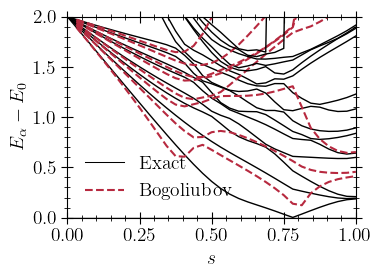

In [36]:
figure(figsize=(4, 3))
subplot(111)
for i in 1:size(bogo_spec)[1]
    plot(exact_times[2:end], bogo_spec[i, :], "--C1", lw=1.5, alpha=1, ms=2)
    plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=1, alpha=1, ms=2)    
end
plot([], [], "-k", lw=0.75, label="Exact")
plot([], [], "--C1", lw=1.5, label="Bogoliubov")
xlim(0., 1.)
ylim(-0., 2)
xlabel("\$s\$")
ylabel("\$E_\\alpha - E_0\$")
legend(frameon=false)
tight_layout()
display(gcf())
PythonPlot.close();

### Eigenstates

In [37]:
all_eigvecs = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_lowest_eigvecs");

In [38]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [39]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

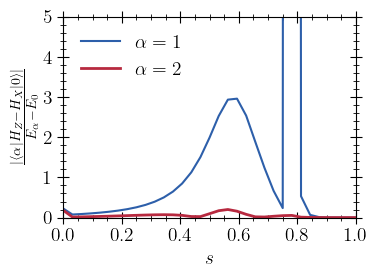

In [40]:
figure(figsize=(4, 3))
ax = subplot(111)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])), label="\$\\alpha = 1\$")
plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :])), label="\$\\alpha = 2\$", lw=2)
xlim(0., 1.)
ylim(0, 5)
xlabel("\$s\$")
ylabel("\$\\frac{|\\langle \\alpha|H_Z-H_X|0\\rangle|}{E_\\alpha - E_0}\$")

legend(frameon=false)

tight_layout()
display(gcf())
PythonPlot.close();

## Annealing

In [64]:
T_anneal = 2.0^15
p = 2^18

linear_schedule(t) = t / T_anneal

# second-order schedule
τ = T_anneal / p
γ = τ .* ((1:p) .- 1/2) ./ p |> collect
β = τ .* (1 .- (1:p) ./ p) |> collect
β[p] = τ / (4 * p);

In [65]:
# annealing_problem = Problem(p, zeros(N), J_mat)
annealing_problem = Problem(p, J_mat)

Problem
  num_qubits: Int64 8
  num_layers: Int64 262144
  local_fields: Array{Real}((8,)) Real[0.32309422, 0.78483851, -0.16609056, -0.23583070, -0.10093322, 0.19120004, -0.23659144, -0.25595258]
  couplings: Array{Real}((8, 8)) Real[0.00000000 -0.39348857 … -0.06529002 0.07952654; -0.39348857 0.00000000 … 0.36906210 -0.04236122; … ; -0.06529002 0.36906210 … 0.00000000 -0.16622131; 0.07952654 -0.04236122 … -0.16622131 0.00000000]
  edges: Array{CartesianIndex{2}}((56,))
  driver: XGate X


In [66]:
H_Z = -hamiltonian(0, 1, annealing_problem.local_fields, annealing_problem.couplings);

In [67]:
# probabs = anneal(annealing_problem, linear_schedule, T_anneal);

In [68]:
using Yao
beta_and_gamma = vcat(β, γ)
circ = QAOA.circuit(annealing_problem)
circ = QAOA.dispatch_parameters!(circ, annealing_problem, beta_and_gamma)
probabs = Yao.uniform_state(Yao.nqubits(circ)) |> circ |> Yao.probs;

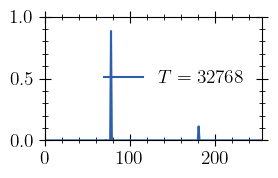

In [69]:
figure(figsize=(3, 2))
plot(probabs, label=@sprintf("\$T = %0.f\$", T_anneal))
xlim(0, 2^annealing_problem.num_qubits)
ylim(0, 1)
legend(frameon=false)
tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

In [70]:
max_prob = maximum(probabs)
max_prob |> println
sol_idxs = findall(x -> x == max_prob, probabs)

0.88406871


1-element Vector{Int64}:
 79

In [71]:
max_prob_2 = maximum(filter(x -> x != max_prob, probabs))
max_prob_2 |> println
sol_idxs_2 = findall(x -> x == max_prob_2, probabs)

0.11307769


1-element Vector{Int64}:
 182

In [72]:
bitstrings = digits.(0:2^annealing_problem.num_qubits-1, base=2, pad=annealing_problem.num_qubits)
vec_dict = Dict(1 => [1, 0], -1 => [0, 1]);

In [73]:
1 .- 2bitstrings[sol_idxs[1]] |> println
1 .- 2bitstrings[sol_idxs_2[1]] |> println

[1, -1, -1, -1, 1, 1, -1, 1]
[-1, 1, -1, 1, -1, -1, 1, -1]


In [78]:
(1 .- 2bitstrings[sol_idxs[1]]) .* (1 .- 2bitstrings[sol_idxs_2[1]]) |> println

[-1, -1, 1, -1, -1, -1, -1, -1]


In [74]:
sol_vec_1 = reduce(kron, [vec_dict[1 - 2z] for z in bitstrings[sol_idxs[1]]]);
sol_vec_2 = reduce(kron, [vec_dict[1 - 2z] for z in bitstrings[sol_idxs_2[1]]]);

In [75]:
sol_vec_1' * H_Z * sol_vec_1 |> println
sol_vec_2' * H_Z * sol_vec_2 |> println

-4.73512320
-4.92144468


In [76]:
max_prob + max_prob_2

0.99714640